In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

import matplotlib.pyplot as plt

The **PennActionDataset** takes the entire Penn Action dataset and reduces it for efficiency. It extracts every 40th frame from each video sequence and its corresponding action.

Action_Map converts the text of the action into a numerical value.

getitem retrieves the image and transforms it. It also retireves the corresponding action label and converts it to tensor. It returns a tuple of the transformed image and label. 

In [47]:
# map of all actions 
ACTION_MAP = {
    'baseball_pitch': 0, 'baseball_swing': 1, 'bench_press': 2, 'bowl': 3,
    'clean_and_jerk': 4, 'golf_swing': 5, 'jump_rope': 6, 'jumping_jacks': 7,
    'pullup': 8, 'pushup': 9, 'situp': 10, 'squat': 11,
    'strum_guitar': 12, 'tennis_forehand': 13, 'tennis_serve': 14
}

class PennActionDataset(Dataset):
    def __init__(self, frames_dir, labels_dir, transform=None):
        self.frames_dir = frames_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.frame_paths = []
        self.action_labels = []
        
        image_sequence_folders = sorted(os.listdir(frames_dir))
        
        for seq_folder in image_sequence_folders:
            if seq_folder != ".DS_Store":
                seq_frames_path = os.path.join(frames_dir, seq_folder)
                
                frames = sorted(os.listdir(seq_frames_path))
                if frames[0] == ".DS_Store":
                    frames.remove(".DS_Store")

                sampled_frames = frames[::40]
                for frame in sampled_frames:
                    frame_path = os.path.join(seq_frames_path, frame)
                              
                    self.frame_paths.append(frame_path)
                
                    label_path = os.path.join(labels_dir, seq_folder + '.mat')
                    annotation = loadmat(label_path)
                    action_label = annotation['action'][0]
                    self.action_labels.append(ACTION_MAP[action_label])
    
    def __getitem__(self, idx):
        img_path = self.frame_paths[idx]
        img = Image.open(img_path)
        
        if self.transform:
            img = self.transform(img)
        
        label = torch.tensor(self.action_labels[idx])
        return img, label

    def __len__(self):
        return len(self.frame_paths)


In [48]:
# Resize
# Convert to Tensor 
# Normilaztion
    # mean: average intensity of each color channel (R,G,B)
    # std: stdev of pixel intensity 
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet normalize
])

# Load dataset
frames_dir = '/Users/jnehra/Desktop/ML/Penn_Action/frames'
labels_dir = '/Users/jnehra/Desktop/ML/Penn_Action/labels'

dataset = PennActionDataset(frames_dir, labels_dir, transform=transform)

In [49]:
# CNN model 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 15) # 15 outputs 
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten
        x = x.view(-1, 32 * 56 * 56)
        x = F.relu(self.fc1(x))
        # Output layer
        x = self.fc2(x)
        return x

CNN Model based off of: https://medium.com/@foxmike/cnn-for-image-classification-4d655c26b487

In [50]:
labels = [dataset.action_labels[i] for i in range(len(dataset))]

# Stratified split
train_indices, test_indices = train_test_split(
    range(len(dataset)), 
    test_size=0.2, 
    stratify=labels, 
    random_state=42
)

# Create subsets
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = CNN().to(device)

Using device: cpu


In [51]:
# Cross-entropy loss as the loss function
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [52]:
test_losses = []
test_accuracies = []

epochs = 15
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # training 
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # backpropagation 
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()  # weight update 
    
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # testing 
    # Set model to eval mode 
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    test_losses.append(val_loss/len(test_loader))
    test_accuracies.append(100 * val_correct / val_total)

    print(f"Epoch {epoch+1}/{epochs}: "
          f"Train Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {100 * correct/total:.2f}%, "
          f"Validation Loss: {val_loss/len(test_loader):.4f}, Validation Accuracy: {100 * val_correct/val_total:.2f}%")


Epoch 1/15: Train Loss: 2.4227, Train Accuracy: 20.40%, Validation Loss: 2.1834, Validation Accuracy: 30.67%
Epoch 2/15: Train Loss: 1.9267, Train Accuracy: 38.91%, Validation Loss: 1.8787, Validation Accuracy: 39.43%
Epoch 3/15: Train Loss: 1.4243, Train Accuracy: 56.95%, Validation Loss: 1.5177, Validation Accuracy: 50.76%
Epoch 4/15: Train Loss: 0.9608, Train Accuracy: 71.22%, Validation Loss: 1.1309, Validation Accuracy: 66.00%
Epoch 5/15: Train Loss: 0.5827, Train Accuracy: 82.68%, Validation Loss: 1.0276, Validation Accuracy: 69.90%
Epoch 6/15: Train Loss: 0.3153, Train Accuracy: 91.30%, Validation Loss: 0.8730, Validation Accuracy: 74.00%
Epoch 7/15: Train Loss: 0.1520, Train Accuracy: 96.35%, Validation Loss: 0.7272, Validation Accuracy: 79.24%
Epoch 8/15: Train Loss: 0.0705, Train Accuracy: 98.57%, Validation Loss: 0.7319, Validation Accuracy: 80.95%
Epoch 9/15: Train Loss: 0.0435, Train Accuracy: 99.26%, Validation Loss: 0.7540, Validation Accuracy: 80.48%
Epoch 10/15: Train 

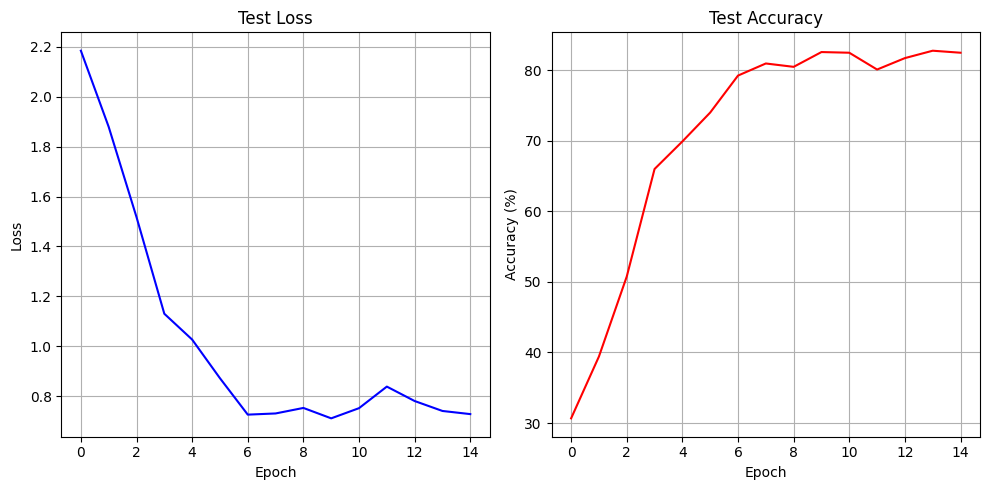

In [53]:
# Plotting
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), test_losses, label='Test Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(epochs), test_accuracies, label='Test Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()